# Путешествие по Спрингфилду.

 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)



### Установка зависимостей

In [1]:
!pip install -U torch torchvision

     |██████████████████████████████▎ | 834.1 MB 1.3 MB/s eta 0:00:37tcmalloc: large alloc 1147494400 bytes == 0x55fa7fb68000 @  0x7fa15a79b615 0x55fa1a3344cc 0x55fa1a41447a 0x55fa1a3372ed 0x55fa1a428e1d 0x55fa1a3aae99 0x55fa1a3a59ee 0x55fa1a338bda 0x55fa1a3aad00 0x55fa1a3a59ee 0x55fa1a338bda 0x55fa1a3a7737 0x55fa1a429c66 0x55fa1a3a6daf 0x55fa1a429c66 0x55fa1a3a6daf 0x55fa1a429c66 0x55fa1a3a6daf 0x55fa1a339039 0x55fa1a37c409 0x55fa1a337c52 0x55fa1a3aac25 0x55fa1a3a59ee 0x55fa1a338bda 0x55fa1a3a7737 0x55fa1a3a59ee 0x55fa1a338bda 0x55fa1a3a6915 0x55fa1a338afa 0x55fa1a3a6c0d 0x55fa1a3a59ee
     |████████████████████████████████| 881.9 MB 16 kB/s 
     |████████████████████████████████| 23.3 MB 11.9 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvisi

In [2]:
!pip3 install wheel==0.34.1

  Attempting uninstall: wheel
    Found existing installation: wheel 0.37.0
    Uninstalling wheel-0.37.0:
      Successfully uninstalled wheel-0.37.0


In [3]:
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

  ERROR: HTTP error 403 while getting http://download.pytorch.org/whl/cu110/torch-0.4.1-cp37-cp37m-linux_x86_64.whl
ERROR: Could not install requirement torch==0.4.1 from http://download.pytorch.org/whl/cu110/torch-0.4.1-cp37-cp37m-linux_x86_64.whl because of HTTP error 403 Client Error: Forbidden for url: http://download.pytorch.org/whl/cu110/torch-0.4.1-cp37-cp37m-linux_x86_64.whl for URL http://download.pytorch.org/whl/cu110/torch-0.4.1-cp37-cp37m-linux_x86_64.whl


In [4]:
import torch
import torchvision
import numpy as np
from torch import nn, optim
train_on_gpu = torch.cuda.is_available()
from torchvision import datasets, models, transforms
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [5]:
!pip uninstall -y Pillow
!pip install Pillow==5.3.0
import PIL
print(PIL.PILLOW_VERSION)

Found existing installation: Pillow 7.1.2
Uninstalling Pillow-7.1.2:
  Successfully uninstalled Pillow-7.1.2
     |████████████████████████████████| 2.0 MB 12.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bokeh 2.3.3 requires pillow>=7.1.0, but you have pillow 5.3.0 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


7.1.2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in a future release. Use __version__ instead.
  after removing the cwd from sys.path.


In [6]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [7]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

In [8]:
!ls train

simpsons_dataset


In [9]:
!nvidia-smi
import torch
torch.cuda.is_available()

Wed Dec 22 12:25:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

В нашем тесте будет 990 картнок, для которых нам будет необходимо предсказать класс.

In [10]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [11]:

DATA_MODES = ['train', 'val', 'test']

RESCALE_SIZE = 224

DEVICE = torch.device("cuda")

Ниже я использую специальный класс для подготовки данных к обучаемому виду.

Я делаю label encoding над всеми классами (симпсонами) обучаеющего и валидационного датасетов.

В методе __getitem__ я произвожу различные преобразования над данными (аугментация, преобразование в тензор, нормировка), чтобы увеличить обучаемую выборку и сделать все картинки одинакового размера.

In [12]:
class SimpsonsDataset(Dataset):

    def __init__(self, files, mode):
        super().__init__()

        self.files = sorted(files)

        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        transform = {
            'val': transforms.Compose([
                transforms.Resize(RESCALE_SIZE),
                transforms.CenterCrop(RESCALE_SIZE),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
            'train': transforms.Compose([
                transforms.Resize(256),
                transforms.RandomResizedCrop(RESCALE_SIZE),
                transforms.ColorJitter(hue=.05, saturation=.05),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(20),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])}
        x = self.load_sample(self.files[index])
        if self.mode == 'test':
            x = transform['val'](x)
            return x
        else:
            label = self.labels[index]
            x=transform[self.mode](x)
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

Функция для отрисовки картинок в формате тензоров

In [13]:
def imshow(inp, title=None, plt_ax=plt, default=False):

    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

Достаем данные

In [14]:
from pathlib import Path
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

Разделяем данные на выборки

In [15]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [16]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Давайте посмотрим на наших героев внутри датасета

UnidentifiedImageError: ignored

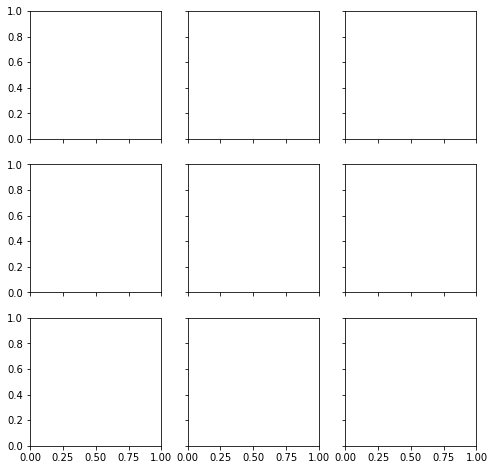

In [17]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Обучение одной эпохи

In [ ]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

Валидация на одной эпохе

In [ ]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

Сам код обучения модели.

In [ ]:
def train(train_files, val_files, model, opt, criterion, epochs, batch_size, scheduler):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    best_model = model.state_dict()
    best_acc = 0.0

    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
            if val_acc > best_acc:
                best_acc = val_acc
                best_model = model.state_dict()

            scheduler.step()
    model.load_state_dict(best_model)        
    return history, model

Функция предсказания

In [ ]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

Я использовал модель efficientnet b6. К ней я пришел после двух других моделей (ResNet и Inception v3). Разумеется, я не обучал их с нуля (хотя попытался, но колаб быстро сказал мне, что его память кончилась). Я использовал fine-tuning и заменил последний слой классификатора на тот, который нам нужен. Дропаут был в модели изначально и я не стал его исключать.

In [ ]:
n_classes = len(np.unique(train_val_labels))
my_model = models.efficientnet_b6(pretrained=True, progress=True)
my_model.classifier=nn.Sequential(
    nn.Dropout(p=0.5, inplace=True),
    nn.Linear(in_features=2304, out_features=n_classes, bias=True)
  )

В модели было всего 7 слоев и я решил заморозить первые 3 слоя и обучать модель на последних четырех. Я пробовал замораживать 4 и 5 слоев, но модель выдавала ощутимо хуже результаты. Про время обучения - да, было достаточно долго (порядка 2-4-х часов каждая модель), но благо я делал все не в последний день. На этапе подбора гиперпараметров меня так задолбал колаб, что мне пришлось купить pro версию, чтобы не приходилось ждать по нескольку часов. Теперь обучения скажем на 15 эпохах занимало не 4 часа, а 1.5

In [ ]:
layers_to_unfreeze = 4
for param in my_model.features[:-layers_to_unfreeze].parameters():
    param.requires_grad = False

Да, я также использовал scheduler для learning rate. Сначала я сомневался в его полезности, потому что оптимайзер, который я выбрал (AdamW) и так внутри себя изменяет learning rate. Однако потом выяснил, что внутри него тоже есть константа лямбда, которая по сути является learning rate нашей модели. А уже learning rate для каждого отдельно веса вычисляется на основе лямбды. Поэтому я решил, что модель еще можно будет улучшить. 

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer=torch.optim.AdamW(my_model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=3, gamma=0.5, verbose=True)

Смотрел на количество классов модели и на саму модель.

P.S. можете расскомментить последнюю строчку и сами посмотреть на полную модель. Она прекрасна!

In [ ]:
my_model.to(DEVICE)
my_model.aux_logits = False
print("we will classify :{}".format(n_classes))
print(my_model)

Запустим обучение сети.

Да, хочу немного рассказать про гиперпараметры модели, которые я подбирал.
- epochs
- batch_size
- scheduler step_size
- scheduler gamma
- optimizer lr
- layers to unfreeze
- optimizer weight decay
- dropout p

Что я еще подбирал.
- scheduler (StepLR, ExponentialLR)
- optimizer (Adam, AdamW, AdaGrad, SGD, RMSProp)
- criterion (NLLLoss, CrossEntropyLoss, BCELoss)
- augmentation (ColorJitter, RandomHorizontalFlip, RandomRotation)

Во всех промежуточных параметрах, которые не вошли в конечный результат, я тоже подбирал отдельные гиперпараметры (learning rate, step_size, и т.д.)

In [ ]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
history, my_model = train(train_dataset, val_dataset, my_model, optimizer, criterion, epochs=15, batch_size=32, scheduler=scheduler)

epoch:   0%|          | 0/15 [00:00<?, ?it/s]

loss 0.7640013959698028


epoch:   7%|▋         | 1/15 [07:40<1:47:29, 460.68s/it]


Epoch 001 train_loss: 0.7640     val_loss 0.2965 train_acc 0.8041 val_acc 0.9339
Adjusting learning rate of group 0 to 1.0000e-03.
loss 0.7166788195552276


epoch:  13%|█▎        | 2/15 [15:12<1:38:40, 455.44s/it]


Epoch 002 train_loss: 0.7167     val_loss 0.1927 train_acc 0.8153 val_acc 0.9524
Adjusting learning rate of group 0 to 1.0000e-03.
loss 0.6567917377206579


epoch:  20%|██        | 3/15 [22:45<1:30:54, 454.52s/it]


Epoch 003 train_loss: 0.6568     val_loss 0.1904 train_acc 0.8308 val_acc 0.9519
Adjusting learning rate of group 0 to 5.0000e-04.
loss 0.49217484289540236


epoch:  27%|██▋       | 4/15 [30:19<1:23:17, 454.33s/it]


Epoch 004 train_loss: 0.4922     val_loss 0.1140 train_acc 0.8673 val_acc 0.9719
Adjusting learning rate of group 0 to 5.0000e-04.
loss 0.4559117952432061


epoch:  33%|███▎      | 5/15 [37:54<1:15:45, 454.58s/it]


Epoch 005 train_loss: 0.4559     val_loss 0.1042 train_acc 0.8798 val_acc 0.9736
Adjusting learning rate of group 0 to 5.0000e-04.
loss 0.4176386229129603


epoch:  40%|████      | 6/15 [45:31<1:08:17, 455.28s/it]


Epoch 006 train_loss: 0.4176     val_loss 0.1133 train_acc 0.8881 val_acc 0.9729
Adjusting learning rate of group 0 to 2.5000e-04.
loss 0.37604014188548596


epoch:  47%|████▋     | 7/15 [53:09<1:00:49, 456.19s/it]


Epoch 007 train_loss: 0.3760     val_loss 0.0913 train_acc 0.8991 val_acc 0.9792
Adjusting learning rate of group 0 to 2.5000e-04.
loss 0.36892099465734185


epoch:  53%|█████▎    | 8/15 [1:00:50<53:23, 457.59s/it]


Epoch 008 train_loss: 0.3689     val_loss 0.0853 train_acc 0.9013 val_acc 0.9790
Adjusting learning rate of group 0 to 2.5000e-04.
loss 0.3345654872949962


epoch:  60%|██████    | 9/15 [1:08:30<45:49, 458.31s/it]


Epoch 009 train_loss: 0.3346     val_loss 0.0866 train_acc 0.9088 val_acc 0.9792
Adjusting learning rate of group 0 to 1.2500e-04.
loss 0.31938222451505105


epoch:  67%|██████▋   | 10/15 [1:16:10<38:14, 458.96s/it]


Epoch 010 train_loss: 0.3194     val_loss 0.0762 train_acc 0.9131 val_acc 0.9840
Adjusting learning rate of group 0 to 1.2500e-04.
loss 0.3032328064769793


epoch:  73%|███████▎  | 11/15 [1:23:52<30:40, 460.01s/it]


Epoch 011 train_loss: 0.3032     val_loss 0.0715 train_acc 0.9170 val_acc 0.9843
Adjusting learning rate of group 0 to 1.2500e-04.
loss 0.29025365982169793


epoch:  80%|████████  | 12/15 [1:31:34<23:01, 460.48s/it]


Epoch 012 train_loss: 0.2903     val_loss 0.0697 train_acc 0.9208 val_acc 0.9853
Adjusting learning rate of group 0 to 6.2500e-05.
loss 0.29104015108166365


epoch:  87%|████████▋ | 13/15 [1:39:12<15:19, 459.87s/it]


Epoch 013 train_loss: 0.2910     val_loss 0.0652 train_acc 0.9222 val_acc 0.9866
Adjusting learning rate of group 0 to 6.2500e-05.
loss 0.2561309634770692


epoch:  93%|█████████▎| 14/15 [1:46:51<07:39, 459.57s/it]


Epoch 014 train_loss: 0.2561     val_loss 0.0701 train_acc 0.9290 val_acc 0.9861
Adjusting learning rate of group 0 to 6.2500e-05.
loss 0.26461365598103403


epoch: 100%|██████████| 15/15 [1:54:28<00:00, 457.88s/it]



Epoch 015 train_loss: 0.2646     val_loss 0.0674 train_acc 0.9266 val_acc 0.9861
Adjusting learning rate of group 0 to 3.1250e-05.


Построим кривые обучения

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

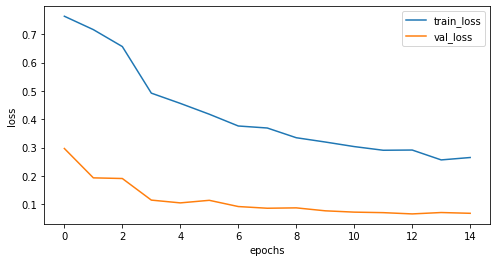

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

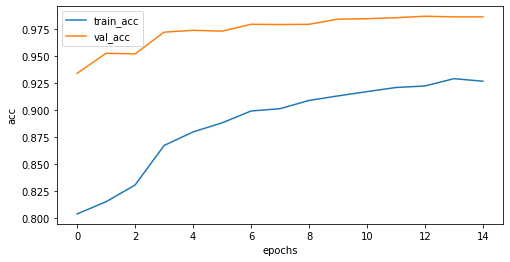

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

Нет, это не ошибка, что валидационная accuracy выше обучаемой. Все дело как раз в аугментации, которая сильнее карает нашу модель на стадии обучения, зато на валидационные данные она приходит избитая, но подготовленная. 

### Сабмит. Ничего интересного.

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(my_model, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(my_model, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

Обратим внимание, что метрика, которую необходимо оптимизировать в конкурсе -- f1-score. Вычислим целевую метрику на валидационной выборке.

In [ ]:
print(actual_labels)
print(preds_class)
print(y_pred)

[1, 0, 4, 0, 4, 0, 0, 2, 2, 4, 2, 0, 6, 0, 0, 2, 4, 6, 2, 0]
['agnes_skinner', 'abraham_grampa_simpson', 'bart_simpson', 'abraham_grampa_simpson', 'bart_simpson', 'abraham_grampa_simpson', 'abraham_grampa_simpson', 'apu_nahasapeemapetilon', 'apu_nahasapeemapetilon', 'bart_simpson', 'apu_nahasapeemapetilon', 'abraham_grampa_simpson', 'charles_montgomery_burns', 'abraham_grampa_simpson', 'abraham_grampa_simpson', 'apu_nahasapeemapetilon', 'bart_simpson', 'charles_montgomery_burns', 'apu_nahasapeemapetilon', 'abraham_grampa_simpson']
[1 0 4 0 4 0 0 2 2 4 2 0 6 0 0 2 4 6 2 0]


In [ ]:
from sklearn.metrics import f1_score

f1_score(np.array(actual_labels), y_pred, average="weighted")


1.0

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах.

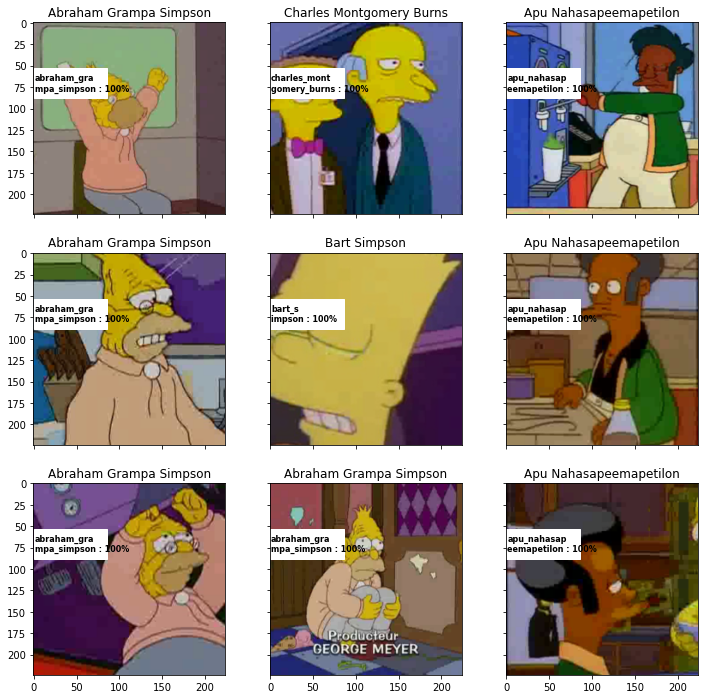

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    prob_pred = predict_one_sample(my_model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left',
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(my_model, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [ ]:
! ls 

characters_illustration.png  label_encoder.pkl	sample_submission.csv  train
gdrive			     sample_data	testset


In [ ]:
import pandas as pd
#my_submit = pd.read_csv("gdrive/My Drive/simpsons/data/labels.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
my_submit.to_csv('/content/gdrive/MyDrive/Colab Notebooks/simpsons/Simpsons_result.csv', index=False)

Вот результат с кагла

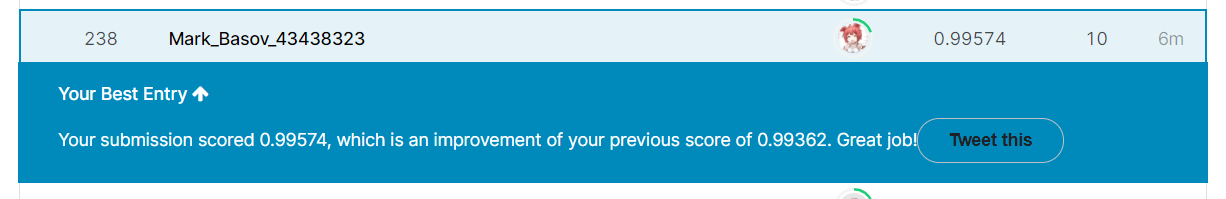

А теперь просто немного истории создания такой модели:

01.12 |||| Первый мой сабмит на SimpleCNN модели: Accuracy **0.67800**

02.12 |||| Использовал голый fine-tuning на efficient net b6: Accuracy **0.88416**.

03.12 |||| Добавил аугментацию, оптимизировал все гиперпараметры модели: Accuracy **0.96705**

04.12-05.12 |||| Оптимизировал гиперпараметры, но не добился никаких результатов

06.12 |||| Продолжал оптимизировать гиперпараметры модели: Accuracy **0.96811**

07.12 |||| Добавил scheduler и еще муторно оптимизировал гиперпараметры модели: Accuracy **0.98831**

08.12 |||| Подобрал подходящие параметры scheduler: Accuracy **0.99574**



Я бы еще оптимизировал результат, но мне кажется эти 0.004 ошибки не то, чтобы от самой модели. Может быть технические моменты. Хотя я мог бы добавить ансамблирование моделей, но мне кажется результат уже достаточно хороший.